In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from tqdm.notebook import tqdm

%matplotlib inline

Сырые данные
Считываем данные из .csv¶

Некоторые данные (такие как рубрики и признаки), представлены строками значений. Преобразуем их в списки чисел.

In [3]:
to_list = lambda rubrics: [int(rubric) for rubric in str(rubrics).split(' ')]
def apply_to_columns(df, columns, func=to_list):
    for column in columns:
        df.loc[~df[column].isnull(), column] = df.loc[~df[column].isnull(), column].apply(func)

users = pd.read_csv('data/users.csv')

orgs = pd.read_csv('data/organisations.csv')

# create lists
columns = ['rubrics_id', 'features_id']
apply_to_columns(orgs, columns)

orgs.head()

,org_id,city,average_bill,rating,rubrics_id,features_id
0,16848414477362211020,spb,1000.0,4.479702,"[30776, 31375]","[1018, 1509, 11177, 11617, 11629, 11704, 11867..."
1,1430604733320164116,spb,1000.0,4.514509,"[30776, 30770]","[246, 1018, 11617, 11629, 11704, 11867, 20422,..."
2,9880309324224147401,spb,1000.0,3.884615,"[30770, 30774]","[1018, 11177, 11617, 11629, 11704, 11867, 2042..."
3,5617879987171966456,spb,1000.0,NaN,"[30774, 30775]","[1018, 1509, 10596, 11177, 11629, 11634, 11704..."
4,5241461680470612149,spb,1000.0,4.532468,[30776],"[1018, 11177, 11617, 11629, 11704, 11867, 2042..."


Чтобы не делать join каждый раз, когда нам потребуется узнать, из какого города организация или пользователь, сразу добавим эту информацию в отзывы.

In [4]:
reviews = pd.read_csv('data/reviews.csv', low_memory=False)

# encode users ids as numeric
reviews = reviews.merge(users, on='user_id')
reviews = reviews.rename({'city': 'user_city'}, axis=1)

# # encode orgs ids as numeric
reviews = reviews.merge(orgs[['org_id', 'city']], on='org_id')
reviews = reviews.rename({'city': 'org_city'}, axis=1)

# # create lists
columns = ['aspects']
apply_to_columns(reviews, columns)

reviews.head()

,user_id,org_id,rating,ts,aspects,user_city,org_city
0,16998268288908323644,7184895086928047809,2.0,105,NaN,msk,msk
1,3121447338909258868,7184895086928047809,5.0,464,NaN,msk,msk
2,1970649778250883025,7184895086928047809,3.0,789,NaN,msk,msk
3,7554889464530643866,7184895086928047809,4.0,936,NaN,msk,msk
4,15907910894057053620,7184895086928047809,1.0,1143,NaN,msk,msk


Отлично, теперь с отзывами будет удобно работать.

Посмотрим на распределение новых отзывов по дням, чтобы понять, как лучше организовать валидацию.

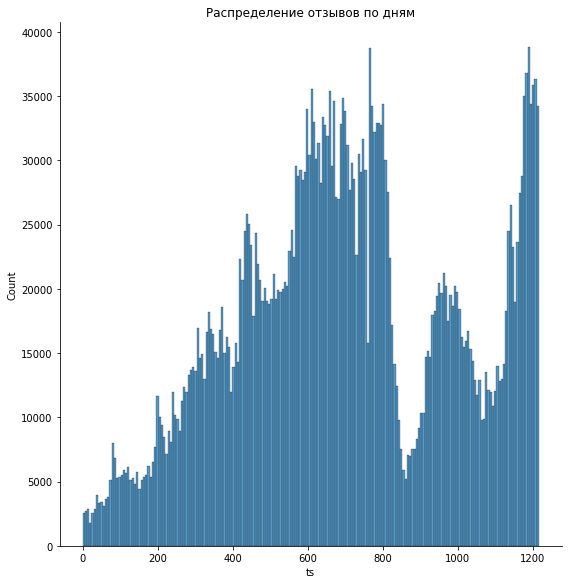

In [5]:
sns.displot(data=reviews, x='ts', height=8)
plt.title('Распределение отзывов по дням')
plt.show()

Train-test split

In [6]:
def clear_df(df, suffixes=['_x', '_y'], inplace=True):
    """
    clear_df(df, suffixes=['_x', '_y'], inplace=True)
        Удаляет из входного df все колонки, оканчивающиеся на заданные суффиксы.

        Parameters
        ----------
        df : pandas.DataFrame

        suffixies : Iterable, default=['_x', '_y']
            Суффиксы колонок, подлежащих удалению

        inplace : bool, default=True
            Нужно ли удалить колонки "на месте" или же создать копию DataFrame.

        Returns
        -------
        pandas.DataFrame (optional)
            df с удалёнными колонками
    """

    def bad_suffix(column):
        nonlocal suffixes
        return any(column.endswith(suffix) for suffix in suffixes)

    columns_to_drop = [col for col in df.columns if bad_suffix(col)]
    return df.drop(columns_to_drop, axis=1, inplace=inplace)


def extract_unique(reviews, column):
    """
    extract_unique(reviews, column)
        Извлекает уникальные значения из колонки в DataFrame.

        Parameters
        ----------
        reviews : pandas.DataFrame
            pandas.DataFrame, из которого будут извлечены значения.

        column : str
            Имя колонки в <reviews>.

        Returns
        -------
        pandas.DataFrame
            Содержит одну именованную колонку с уникальными значениями.
    """

    unique = reviews[column].unique()
    return pd.DataFrame({column: unique})


def count_unique(reviews, column):
    """
    count_unique(reviews, column)
        Извлекает и подсчитывает уникальные значения из колонки в DataFrame.

        Parameters
        ----------
        reviews : pandas.DataFrame
            pandas.DataFrame, из которого будут извлечены значения.

        column : str
            Имя колонки в <reviews>.

        Returns
        -------
        pandas.DataFrame
            Содержит две колонки: с уникальными значениями и счётчиком встреченных.
    """

    return reviews[column].value_counts().reset_index(name='count').rename({'index': column}, axis=1)



def filter_reviews(reviews, users=None, orgs=None):
    """
    filter_reviews(reviews, users=None, orgs=None)
    Оставляет в выборке только отзывы, оставленные заданными пользователями на заданные организации.

    Parameters
    ----------
        users: pandas.DataFrame, default=None
            DataFrame, содержащий колонку <user_id>.
            Если None, то фильтрация не происходит.

        orgs: pandas.DataFrame, default=None
            DataFrame, содержащий колонку <org_id>.
            Если None, то фильтрация не происходит.

    Returns
    -------
        pandas.DataFrame
            Отфильтрованная выборка отзывов.

    """
    if users is not None:
        reviews = reviews.merge(users, on='user_id', how='inner')
        clear_df(reviews)

    if orgs is not None:
        reviews = reviews.merge(orgs, on='org_id', how='inner')
        clear_df(reviews)

    return reviews


def train_test_split(reviews, ts_start, ts_end=None):
    """
    train_test_split(reviews, ts_start, ts_end=None)
        Разделяет выборку отзывов на две части: обучающую и тестовую.
        В тестовую выборку попадают только отзывы с user_id и org_id, встречающимися в обучающей выборке.

        Parameters
        ----------
        reviews : pandas.DataFrame
            Отзывы из reviews.csv с обязательными полями:
                <rating>, <ts>, <user_id>, <user_city>, <org_id>, <org_city>.

        ts_start : int
            Первый день отзывов из тестовой выборки (включительно).

        ts_end : int, default=None
            Последний день отзывов из обучающей выборки (включительно)
            Если параметр равен None, то ts_end == reviews['ts'].max().

        Returns
        -------
        splitting : tuple
            Кортеж из двух pandas.DataFrame такой же структуры, как и reviews:
            в первом отзывы, попавшие в обучающую выборку, во втором - в тестовую.
    """

    if not ts_end:
        ts_end = reviews['ts'].max()


    reviews_train = reviews[(reviews['ts'] < ts_start) | (reviews['ts'] > ts_end)]
    reviews_test = reviews[(ts_start <= reviews['ts']) & (reviews['ts'] <= ts_end)]

    # 1. Выбираем только отзывы на понравившиеся места у путешественников
    reviews_test = reviews_test[reviews_test['rating'] >= 4.0]
    reviews_test = reviews_test[reviews_test['user_city'] != reviews_test['org_city']]

    # 2. Оставляем в тесте только тех пользователей и организации, которые встречались в трейне
    train_orgs = extract_unique(reviews_train, 'org_id')
    train_users = extract_unique(reviews_train, 'user_id')

    reviews_test = filter_reviews(reviews_test, orgs=train_orgs)

    return reviews_train, reviews_test


def process_reviews(reviews):
    """
    process_reviews(reviews)
        Извлекает из набора отзывов тестовых пользователей и таргет.

        Parameters
        ----------
        reviews : pandas.DataFrame
            DataFrame с отзывами, содержащий колонки <user_id> и <org_id>

        Returns
        -------
        X : pandas.DataFrame
            DataFrame такой же структуры, как и в test_users.csv

        y : pandas.DataFrame
            DataFrame с колонками <user_id> и <target>.
            В <target> содержится список org_id, посещённых пользователем.
    """

    y = reviews.groupby('user_id')['org_id'].apply(list).reset_index(name='target')
    X = pd.DataFrame(y['user_id'])

    return X, y

In [7]:
reviews['ts'].max()

1216

Всего в выборку попали отызывы за 1216 дней.
Отложим в тестовую выборку отзывы за последние 100 дней.

In [8]:
train_reviews, test_reviews = train_test_split(reviews, 1116)
X_test, y_test = process_reviews(test_reviews)

Посмотрим, сколько всего уникальных пользователей попало в эту тестовую выборку:

In [9]:
len(X_test)

12044

### Метрика

Метрика принимает на вход два DataFrame, имеющих такую же структуру, как и y_test.
print_score домножает реальное значение метрики на 100 так же, как и в контесте.
Подобная имплементация используется для оценки submission.

In [10]:
def MNAP(size=20):
    """
    MNAP(size=20)
        Создаёт метрику под <size> сделанных предсказаний.

        Parameters
        ----------
        size : int, default=20
            Размер рекомендованной выборки для каждого пользователя

        Returns
        -------
        func(pd.DataFrame, pd.DataFrame) -> float
            Функция, вычисляющая MNAP.

    """

    assert size >= 1, "Size must be greater than zero!"

    def metric(y_true, predictions, size=size):
        """
        metric(y_true, predictions, size=size)
            Метрика MNAP для двух перемешанных наборов <y_true> и <y_pred>.

            Parameters
            ----------
            y_true : pd.DataFrame
                DataFrame с колонками <user_id> и <target>.
                В <target> содержится список настоящих org_id, посещённых пользователем.

            predictions : pd.DataFrame
                DataFrame с колонками <user_id> и <target>.
                В <target> содержится список рекомендованных для пользователя org_id.

            Returns
            -------
            float
                Значение метрики.
        """

        y_true = y_true.rename({'target': 'y_true'}, axis='columns')
        predictions = predictions.rename({'target': 'predictions'}, axis='columns')

        merged = y_true.merge(predictions, left_on='user_id', right_on='user_id')

        def score(x, size=size):
            """
            Вспомогательная функция.
            """

            y_true = x[1][1]
            predictions = x[1][2][:size]

            weight = 0

            inner_weights = [0]
            for n, item in enumerate(predictions):
                inner_weight = inner_weights[-1] + (1 if item in y_true else 0)
                inner_weights.append(inner_weight)

            for n, item in enumerate(predictions):
                if item in y_true:
                    weight += inner_weights[n + 1] / (n + 1)

            return weight / min(len(y_true), size)

        return np.mean([score(row) for row in merged.iterrows()])


    return metric


def print_score(score):
    print(f"Score: {score*100.0:.2f}")


N = 20
MNAP_N = MNAP(N)

## Попробуем что-нибудь разведать

In [16]:
c = 0
for index, row in users.iterrows():
    # print(row['user_id'], row['city'])
    print("="*40)
    print(len(reviews.loc[reviews['user_id'] == row['user_id']]))
    print(reviews.loc[reviews['user_id'] == row['user_id']])
    c += 1
    if c == 10:
        break


3
                    user_id               org_id  rating    ts aspects  \
359999   523295021912509756  3288896578700040512     5.0   587     NaN   
2792711  523295021912509756  1011843506959814815     5.0  1047     NaN   
3254920  523295021912509756  5145242920031317950     5.0   819     NaN   

        user_city org_city  
359999        msk      spb  
2792711       msk      msk  
3254920       msk      msk  
1
                      user_id               org_id  rating    ts aspects  \
1763058  11952159487361099606  9286993598762204026     5.0  1183     NaN   

        user_city org_city  
1763058       msk      msk  
3
                      user_id                org_id  rating   ts  \
12444    16879036589969590999  12784724396885152442     5.0  565   
1596196  16879036589969590999   5435319468015488972     5.0  230   
2035138  16879036589969590999   1305167628214420687     3.0  565   

              aspects user_city org_city  
12444        [4, 298]       msk      spb  
1596196    

In [36]:
print(X_test.head())
cnt = 0
for index, row in y_test.iterrows():
    if len(row["target"]) > 20:
        cnt += 1
        # print("="*40)
        # print(row)
print(cnt)



            user_id
0  2183246479913987
1  2296072303631704
2  2734551237953758
3  3127332141603176
4  8312342049993844
7
